In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import PFSMG as pfsmg
import functions as func
import pickle

## Two objectives: Equal FNR vs Loss


In [13]:
prob = func.Fairness_LogRe_EO_smoothed('data/CAMPAS_race.txt', 'CAMPAS_race', 1, 112233455, 5278, 'all')
run = pfsmg.Main_SMG(prob)

## key parameters
run.point_per_iteration = 3 
run.num_steps_per_point = 3
run.stepsize = 4.0 
run.step_scheme = 3 
run.batch1_init = 80 
run.batch1_factor = 1.005 
run.batch1_max = 1 
run.batch2_init = 80
run.batch2_factor = 1.005 
run.batch2_max = 1.0/2
run.discount_iter_interval = 100
run.alpha = 1.0/3

## other parameters
run.num_starting_pts = 5
run.percent_explore = 0.4 
run.f1_explore_interval = 12
run.f2_explore_interval = 42 
run.f1_explore_pt_per_iter = 2
run.f2_explore_pt_per_iter = 1
run.max_hole_explore_pt_per_iter = 2*run.point_per_iteration

run.num_max_hole_points = 8 
run.f1_num_steps_per_point = 2*run.num_steps_per_point 
run.f2_num_steps_per_point = run.num_steps_per_point 
run.max_hole_num_steps_per_point = run.num_steps_per_point 
run.max_hole_only = False
run.dense_threshold = 1.0/1200

#All data size:  5278
Sensitive feature index:  1
Sum of positive ones:  2103.0


In [8]:
x = np.random.uniform(prob.lb, prob.ub, [1, prob.n])

In [17]:
print prob.g2(x, alpha = -20.0)

[-5.31069989e-03 -5.31069989e-03 -0.00000000e+00 -1.14630759e-20
 -5.31069989e-03 -5.51864553e-20  1.59202037e-03 -0.00000000e+00]


In [11]:
print prob.g2(x)

[-0.00531067 -0.00531067 -0.         -0.         -0.00531067 -0.
  0.00159201 -0.        ]


In [3]:
f1_arrays7, f2_arrays7, point_arrays7, total_time = run.main_SMG()

time:  0.0747029781342
#Pts:  2  #Iter:  3
time:  0.0317142009735
#Pts:  2  #Iter:  6
time:  0.0309309959412
#Pts:  2  #Iter:  9
time:  0.0320899486542
#Pts:  2  #Iter:  12
time:  0.0304079055786
#Pts:  2  #Iter:  15
time:  0.0306529998779
#Pts:  2  #Iter:  18
time:  0.0309569835663
#Pts:  4  #Iter:  21
time:  0.099091053009
#Pts:  10  #Iter:  24
time:  0.15213394165
#Pts:  5  #Iter:  27
time:  0.132191896439
#Pts:  8  #Iter:  30
time:  0.231755971909
#Pts:  8  #Iter:  33
time:  0.231276988983
#Pts:  16  #Iter:  36
time:  0.24002790451
#Pts:  17  #Iter:  39
time:  0.48407292366
#Pts:  25  #Iter:  42
time:  0.127799034119
#Pts:  33  #Iter:  45
time:  0.84752702713
#Pts:  58  #Iter:  48
time:  0.866475105286
#Pts:  47  #Iter:  51
time:  1.10276198387
#Pts:  38  #Iter:  54
time:  0.956300973892
#Pts:  33  #Iter:  57
time:  0.88390994072
#Pts:  40  #Iter:  60
time:  0.596126794815
#Pts:  41  #Iter:  63
time:  1.04036092758
#Pts:  38  #Iter:  66
time:  0.957412958145
#Pts:  50  #Iter:  69
t

In [6]:
def remove_pts(list_f1, list_f2, list_pts, num):
    list_f1_idx = np.argsort(list_f1)[:-num]
    return list_f1[list_f1_idx], list_f2[list_f1_idx], list_pts[list_f1_idx]

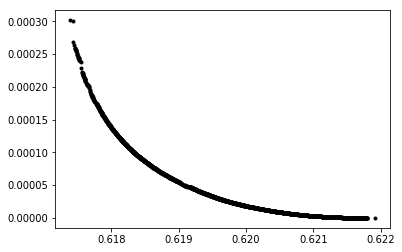

In [7]:
plt.plot(f1_arrays7, f2_arrays7, 'k.')
plt.show()

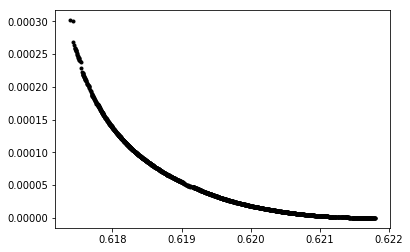

In [8]:
## if necessary, remove extreme points that are far away from Pareto front
f1_arrays7, f2_arrays7, point_arrays7 = remove_pts(f1_arrays7, f2_arrays7, point_arrays7, 2)
plt.plot(f1_arrays7, f2_arrays7, 'k.')
plt.show()

In [10]:
## Compute loss, accuracy, and CV score for points on Pareto front 
M = min(1500, len(f1_arrays7)) 
CV_FPR, CV_FNR, disparate_impact, percentage, pvalue, total_accuracy, training_accuracy, training_FPR, training_FNR, \
training_loss, training_obj1, training_obj2 \
= prob.compute_accuracy(f1_arrays7, f2_arrays7, point_arrays7, M)


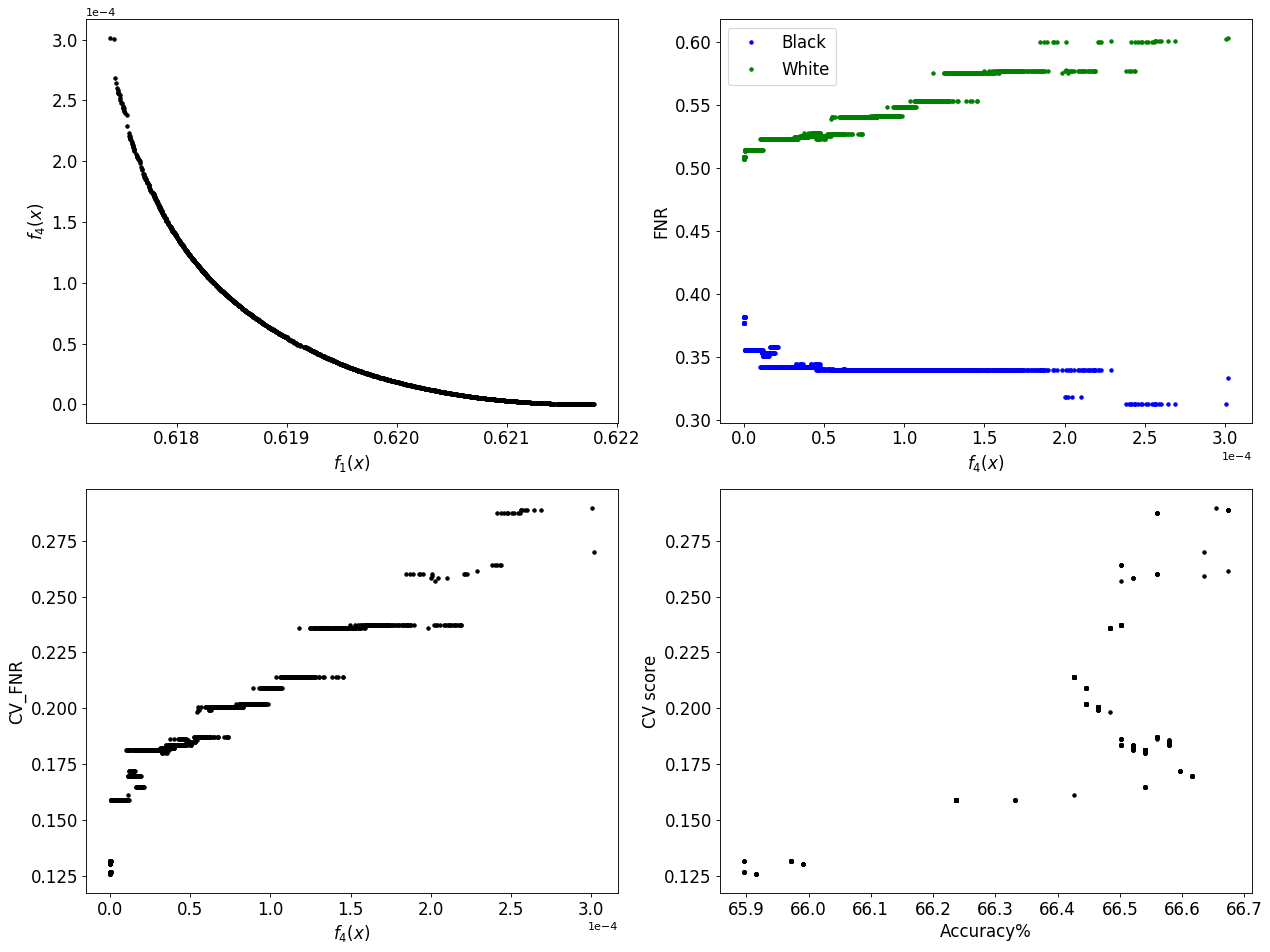

In [11]:
fig = plt.figure(figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(2, 2, 1)
ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.plot(training_loss, training_obj2, 'k.', lw=2)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_xlabel('$f_1(x)$', fontsize=15)
ax1.set_ylabel('$f_4(x)$', fontsize=15)

ax2 = plt.subplot(2, 2, 2)
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.plot(training_obj2, training_FNR[:, 0], 'b.', lw=2, label = 'Black')
ax2.plot(training_obj2, training_FNR[:, 1], 'g.', lw=2, label = 'White')
ax2.set_xlabel('$f_4(x)$', fontsize = 15)
ax2.set_ylabel('FNR', fontsize = 15)
ax2.legend(fontsize = 15)

ax3= plt.subplot(2, 2, 3)
ax3.xaxis.set_tick_params(labelsize=15)
ax3.yaxis.set_tick_params(labelsize=15)
ax3.plot(training_obj2, CV_FNR, 'k.', lw=2)
ax3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax3.set_xlabel('$f_4(x)$', fontsize = 15)
ax3.set_ylabel('CV_FNR', fontsize = 15)

ax4 = plt.subplot(2, 2, 4)
ax4.xaxis.set_tick_params(labelsize=15)
ax4.yaxis.set_tick_params(labelsize=15)
ax4.plot(total_accuracy*100, CV_FNR, 'k.', lw=2)
ax4.set_xlabel('Accuracy%', fontsize = 15)
ax4.set_ylabel('CV score', fontsize = 15)

plt.tight_layout()
plt.show()


## Two objectives: disparate impact vs Equal FNR

In [13]:
prob = func.Fairness_LogRe_DIEO('data/CAMPAS_race.txt', 'CAMPAS_race', 1, 112233455, 5278, 'all')
run = pfsmg.Main_SMG_m2(prob)

## key parameters
run.point_per_iteration = 3 
run.num_steps_per_point = 3
run.stepsize = 2.0 #4.0 
run.step_scheme = 3 
run.batch1_init = 80 
run.batch1_factor = 1.005 
run.batch1_max = 1.0/2 
run.batch2_init = 80
run.batch2_factor = 1.005 
run.batch2_max = 1.0/2
run.discount_iter_interval = 100
run.alpha = 1.0/3

## other parameters
run.num_starting_pts = 5
run.percent_explore = 0.4 
run.f1_explore_interval = 12
run.f2_explore_interval = 42 
run.f1_explore_pt_per_iter = 2
run.f2_explore_pt_per_iter = 1
run.max_hole_explore_pt_per_iter = 2*run.point_per_iteration

run.num_max_hole_points = 8 
run.f1_num_steps_per_point = 2*run.num_steps_per_point 
run.f2_num_steps_per_point = run.num_steps_per_point 
run.max_hole_num_steps_per_point = run.num_steps_per_point 
run.max_hole_only = False
run.dense_threshold = 1.0/1200

#All data size:  5278
Sensitive feature index:  1
Sum of positive ones:  2103.0


In [14]:
f1_arrays7, f2_arrays7, point_arrays7, total_time_smg = run.main_SMG()

time:  0.130766868591
#Pts:  2  #Iter:  3
time:  0.0556659698486
#Pts:  6  #Iter:  6
time:  0.110688924789
#Pts:  9  #Iter:  9
time:  0.16618514061
#Pts:  19  #Iter:  12
time:  0.473633050919
#Pts:  18  #Iter:  15
time:  0.323585033417
#Pts:  20  #Iter:  18
time:  0.37654209137
#Pts:  16  #Iter:  21
time:  0.3097178936
#Pts:  10  #Iter:  24
time:  0.274572134018
#Pts:  15  #Iter:  27
time:  0.291256904602
#Pts:  8  #Iter:  30
time:  0.161765813828
#Pts:  9  #Iter:  33
time:  0.192564964294
#Pts:  9  #Iter:  36
time:  0.238159894943
#Pts:  7  #Iter:  39
time:  0.150332212448
#Pts:  6  #Iter:  42
time:  0.150769948959
#Pts:  7  #Iter:  45
time:  0.137284040451
#Pts:  6  #Iter:  48
time:  0.154870986938
#Pts:  6  #Iter:  51
time:  0.126582860947
#Pts:  7  #Iter:  54
time:  0.139235019684
#Pts:  6  #Iter:  57
time:  0.120620012283
#Pts:  6  #Iter:  60
time:  0.153072118759
#Pts:  6  #Iter:  63
time:  0.1212849617
#Pts:  7  #Iter:  66
time:  0.134107112885
#Pts:  4  #Iter:  69
time:  0.0847

time:  0.140958070755
#Pts:  4  #Iter:  567
time:  0.127328872681
#Pts:  4  #Iter:  570
time:  0.111448049545
#Pts:  4  #Iter:  573
time:  0.116858005524
#Pts:  4  #Iter:  576
time:  0.131716012955
#Pts:  4  #Iter:  579
time:  0.127441883087
#Pts:  4  #Iter:  582
time:  0.120239973068
#Pts:  4  #Iter:  585
time:  0.120225906372
#Pts:  4  #Iter:  588
time:  0.125055074692
#Pts:  4  #Iter:  591
time:  0.123974084854
#Pts:  4  #Iter:  594
time:  0.125541210175
#Pts:  4  #Iter:  597
time:  0.123556137085
#Pts:  4  #Iter:  600
time:  0.126935005188
#Pts:  4  #Iter:  603
time:  0.129248142242
#Pts:  4  #Iter:  606
time:  0.136052131653
#Pts:  4  #Iter:  609
time:  0.126238822937
#Pts:  4  #Iter:  612
time:  0.131946086884
#Pts:  5  #Iter:  615
time:  0.158165931702
#Pts:  6  #Iter:  618
time:  0.176635026932
#Pts:  7  #Iter:  621
time:  0.194363117218
#Pts:  7  #Iter:  624
time:  0.212337017059
#Pts:  7  #Iter:  627
time:  0.215392112732
#Pts:  7  #Iter:  630
time:  0.21564412117
#Pts:  7  #

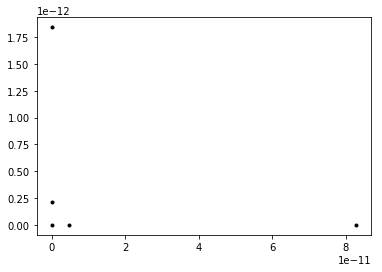

In [16]:
plt.plot(f1_arrays7, f2_arrays7, 'k.')
plt.show()

In [15]:
## dump data into log file
## f1 is DI and f2 is EO
logfile = "pickle/EO_vs_DI/EODIOnly_output2.pickle"
pickle.dump([prob.data_name, total_time, run.num_grad_eval_f1, \
             run.num_grad_eval_f2, run.num_iter, f1_arrays7, \
             f2_arrays7, point_arrays7], open(logfile,"wb"))

## Two objectives: disparate impact vs loss

In [2]:
prob = func.Fairness_LogRe_DI_binary('data/CAMPAS_race.txt', 'CAMPAS_race', 1, 112233455, 5278, 'all')
run = pfsmg.Main_SMG(prob)

## key parameters
run.point_per_iteration = 3 
run.num_steps_per_point = 3
run.stepsize = 2.0 #4.0 
run.step_scheme = 3 
run.batch1_init = 80 
run.batch1_factor = 1.005 
run.batch1_max = 1.0/2 
run.batch2_init = 80
run.batch2_factor = 1.005 
run.batch2_max = 1.0/2
run.discount_iter_interval = 100
run.alpha = 1.0/3

## other parameters
run.num_starting_pts = 5
run.percent_explore = 0.4 
run.f1_explore_interval = 12
run.f2_explore_interval = 42 
run.f1_explore_pt_per_iter = 2
run.f2_explore_pt_per_iter = 1
run.max_hole_explore_pt_per_iter = 2*run.point_per_iteration

run.num_max_hole_points = 8 
run.f1_num_steps_per_point = 2*run.num_steps_per_point 
run.f2_num_steps_per_point = run.num_steps_per_point 
run.max_hole_num_steps_per_point = run.num_steps_per_point 
run.max_hole_only = False
run.dense_threshold = 1.0/1200

# Training data size:  5278
split 1
idx [2 3 4 5 6 7 8 9]
sum of sensitive 2103.0


In [3]:
f1_arrays7, f2_arrays7, point_arrays7, total_time_smg = run.main_SMG()

time:  0.11153793335
#Pts:  5  #Iter:  3
time:  0.0680940151215
#Pts:  2  #Iter:  6
time:  0.0364680290222
#Pts:  9  #Iter:  9
time:  0.120453834534
#Pts:  11  #Iter:  12
time:  0.193476915359
#Pts:  13  #Iter:  15
time:  0.171235084534
#Pts:  19  #Iter:  18
time:  0.245562076569
#Pts:  17  #Iter:  21
time:  0.232491016388
#Pts:  19  #Iter:  24
time:  0.354391098022
#Pts:  20  #Iter:  27
time:  0.24020409584
#Pts:  22  #Iter:  30
time:  0.260288000107
#Pts:  26  #Iter:  33
time:  0.26874089241
#Pts:  26  #Iter:  36
time:  0.394499063492
#Pts:  36  #Iter:  39
time:  0.326369047165
#Pts:  45  #Iter:  42
time:  0.452498197556
#Pts:  51  #Iter:  45
time:  0.436226844788
#Pts:  53  #Iter:  48
time:  0.74152302742
#Pts:  52  #Iter:  51
time:  0.438392877579
#Pts:  53  #Iter:  54
time:  0.440505027771
#Pts:  58  #Iter:  57
time:  0.491715908051
#Pts:  71  #Iter:  60


KeyboardInterrupt: 

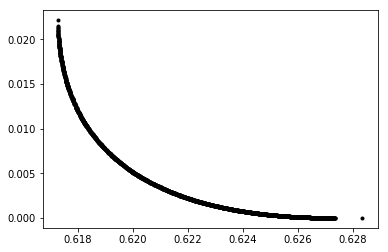

In [4]:
plt.plot(f1_arrays7, f2_arrays7, 'k.')
plt.show()

In [6]:
## f1 is loss and f2 is disparate impact
logfile = "pickle/COMPAS/DI_vs_loss_output1.pickle"
pickle.dump([prob.data_name, total_time_smg, run.num_grad_eval_f1, \
             run.num_grad_eval_f2, run.num_iter, f1_arrays7, \
             f2_arrays7, point_arrays7], open(logfile,"wb"))

In [7]:
M = min(1500, len(f1_arrays7))
CV_Score, percentage, pvalue, total_accuracy, training_accuracy, training_FPR, training_FNR, \
training_loss, training_obj1, training_obj2 \
= prob.compute_accuracy(f1_arrays7, f2_arrays7, point_arrays7, M)


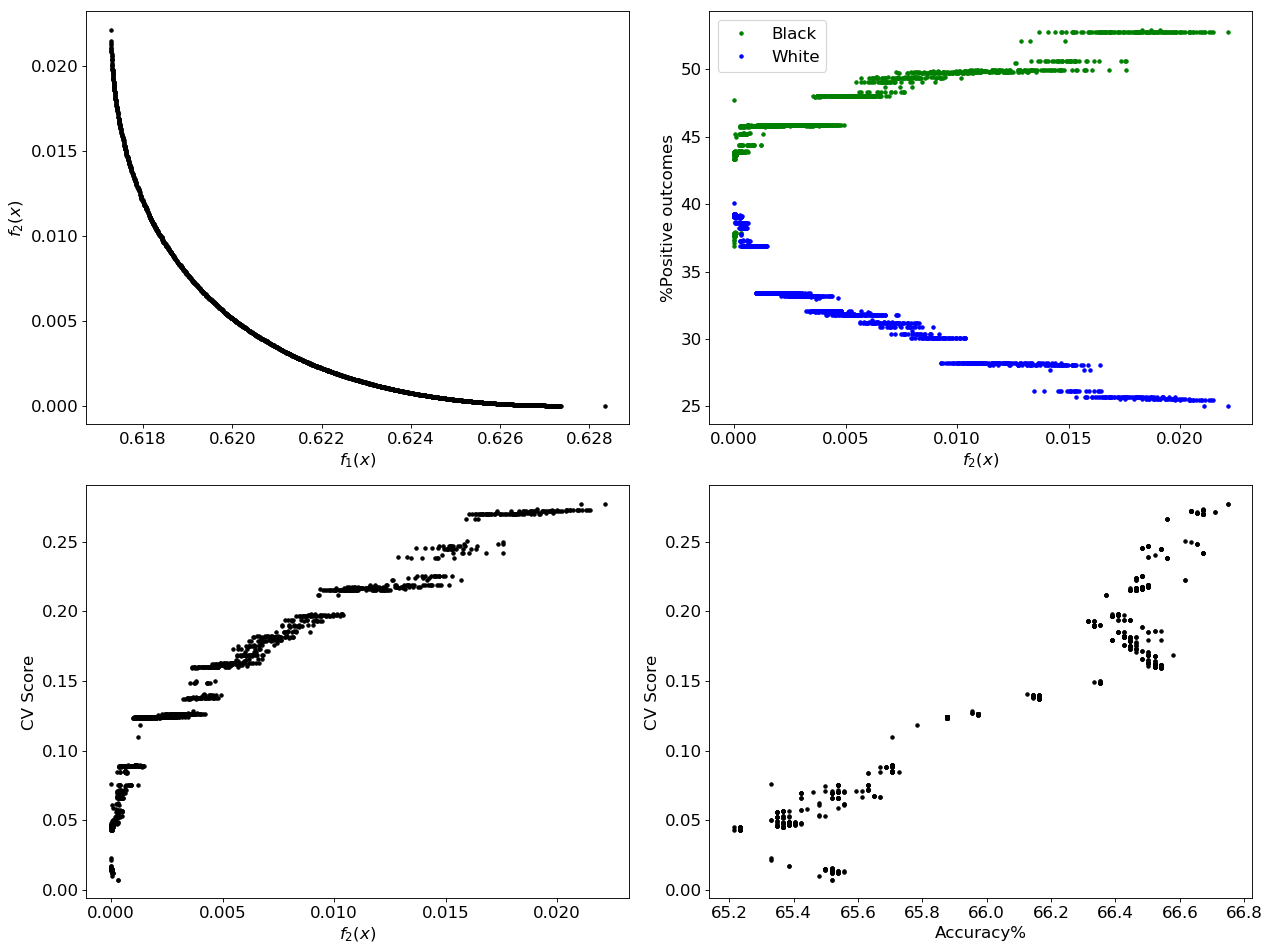

In [8]:
fig = plt.figure(figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(2, 2, 1)
ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.plot(training_loss, training_obj2, 'k.', lw=2)
ax1.set_xlabel('$f_1(x)$', fontsize = 15)
ax1.set_ylabel('$f_2(x)$', fontsize = 15)

ax2 = plt.subplot(2, 2, 2)
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)
ax2.plot(training_obj2, percentage[:, 0]*100.0, 'g.', lw=2, label = 'Black')
ax2.plot(training_obj2, percentage[:, 1]*100.0, 'b.', lw=2, label = 'White')
ax2.set_xlabel('$f_2(x)$', fontsize = 15)
ax2.set_ylabel('%Positive outcomes', fontsize = 15)
ax2.legend(fontsize=15)

ax3= plt.subplot(2, 2, 3)
ax3.xaxis.set_tick_params(labelsize=15)
ax3.yaxis.set_tick_params(labelsize=15)
ax3.plot(training_obj2, CV_Score, 'k.', lw=2)
ax3.set_xlabel('$f_2(x)$', fontsize=15)
ax3.set_ylabel('CV Score', fontsize=15)

ax4 = plt.subplot(2, 2, 4)
ax4.xaxis.set_tick_params(labelsize=15)
ax4.yaxis.set_tick_params(labelsize=15)
ax4.plot(total_accuracy*100.0, CV_Score, 'k.', lw=2)
ax4.set_xlabel('Accuracy%', fontsize=15)
ax4.set_ylabel('CV Score', fontsize=15)

plt.tight_layout()
plt.show()


## Three objectives: disparate impact vs Equal FNR vs loss

In [18]:
prob = func.Fairness_LogRe_DIEO_m3('data/CAMPAS_race.txt', 'CAMPAS_race', 1, 112233455, 5278, 'all')
run = pfsmg.Main_SMG_m3(prob)

run.max_len_pareto_front = 3000
## key parameters
run.point_per_iteration = 3 
run.num_steps_per_point = 3
run.stepsize = 2.0 #4.0 
run.step_scheme = 3 
run.batch1_init = 80 
run.batch1_factor = 1.005 
run.batch1_max = 1.0/2 
run.batch2_init = 80
run.batch2_factor = 1.005 
run.batch2_max = 1.0/2
run.batch3_init = 80
run.batch3_factor = 1.005 
run.batch3_max = 1.0/2
run.discount_iter_interval = 100
run.alpha = 1.0/3

## other parameters
run.num_starting_pts = 5
run.percent_explore = 0.4 
run.f1_explore_interval = 12
run.f2_explore_interval = 42 
run.f1_explore_pt_per_iter = 2
run.f2_explore_pt_per_iter = 1
run.max_hole_explore_pt_per_iter = 2*run.point_per_iteration

run.num_max_hole_points = 8 
run.f1_num_steps_per_point = 2*run.num_steps_per_point 
run.f2_num_steps_per_point = run.num_steps_per_point 
run.max_hole_num_steps_per_point = run.num_steps_per_point 
run.max_hole_only = False
run.dense_threshold = 1.0/1400

#All data size:  5278
Sensitive feature index:  1
Sum of positive ones:  2103.0


In [3]:
f1_arrays7, f2_arrays7, f3_arrays7, point_arrays7, total_time_smg = run.main_SMG()

time:  0.245903968811
#Pts:  4  #Iter:  3
time:  0.152689933777
#Pts:  9  #Iter:  6
time:  0.298406124115
#Pts:  18  #Iter:  9
time:  0.517121076584
#Pts:  25  #Iter:  12
time:  1.15642786026
#Pts:  48  #Iter:  15
time:  1.21246194839
#Pts:  53  #Iter:  18
time:  1.26194906235
#Pts:  76  #Iter:  21
time:  1.60046386719
#Pts:  90  #Iter:  24
time:  3.28571009636
#Pts:  132  #Iter:  27
time:  2.59920501709
#Pts:  145  #Iter:  30
time:  2.86546206474
#Pts:  219  #Iter:  33
time:  4.33256816864
#Pts:  239  #Iter:  36
time:  8.06732797623
#Pts:  289  #Iter:  39
time:  5.03257703781
#Pts:  312  #Iter:  42
time:  6.88484215736
#Pts:  355  #Iter:  45
time:  6.15152788162
#Pts:  348  #Iter:  48
time:  11.9877319336
#Pts:  372  #Iter:  51
time:  6.48610782623
#Pts:  435  #Iter:  54
time:  8.01131415367
#Pts:  461  #Iter:  57
time:  8.17039299011
#Pts:  488  #Iter:  60
time:  16.898362875
#Pts:  516  #Iter:  63
time:  8.62639093399
#Pts:  559  #Iter:  66
time:  9.57598304749
#Pts:  603  #Iter:  6

In [4]:
## dump data into log file
logfile = "pickle/COMPAS/three_obj/EODI_m3_pf3000_gap1400.pickle"
pickle.dump([prob.data_name, total_time_smg, run.num_grad_eval_f1, \
             run.num_grad_eval_f2, run.num_grad_eval_f3, run.num_iter, f1_arrays7, \
             f2_arrays7, f3_arrays7, point_arrays7], open(logfile,"wb"))

In [19]:
logfile = "pickle/COMPAS/three_obj/EODI_m3_pf3000_gap1400.pickle"
data, total_time_smg, num_grad_eval_f1, num_grad_eval_f2, num_grad_eval_f3, num_iter7, f1_arrays7, f2_arrays7, f3_arrays7, point_arrays7 \
= pickle.load(open(logfile,"rb"))

In [30]:
plt.rc('font', **{'size':'20'})

3140


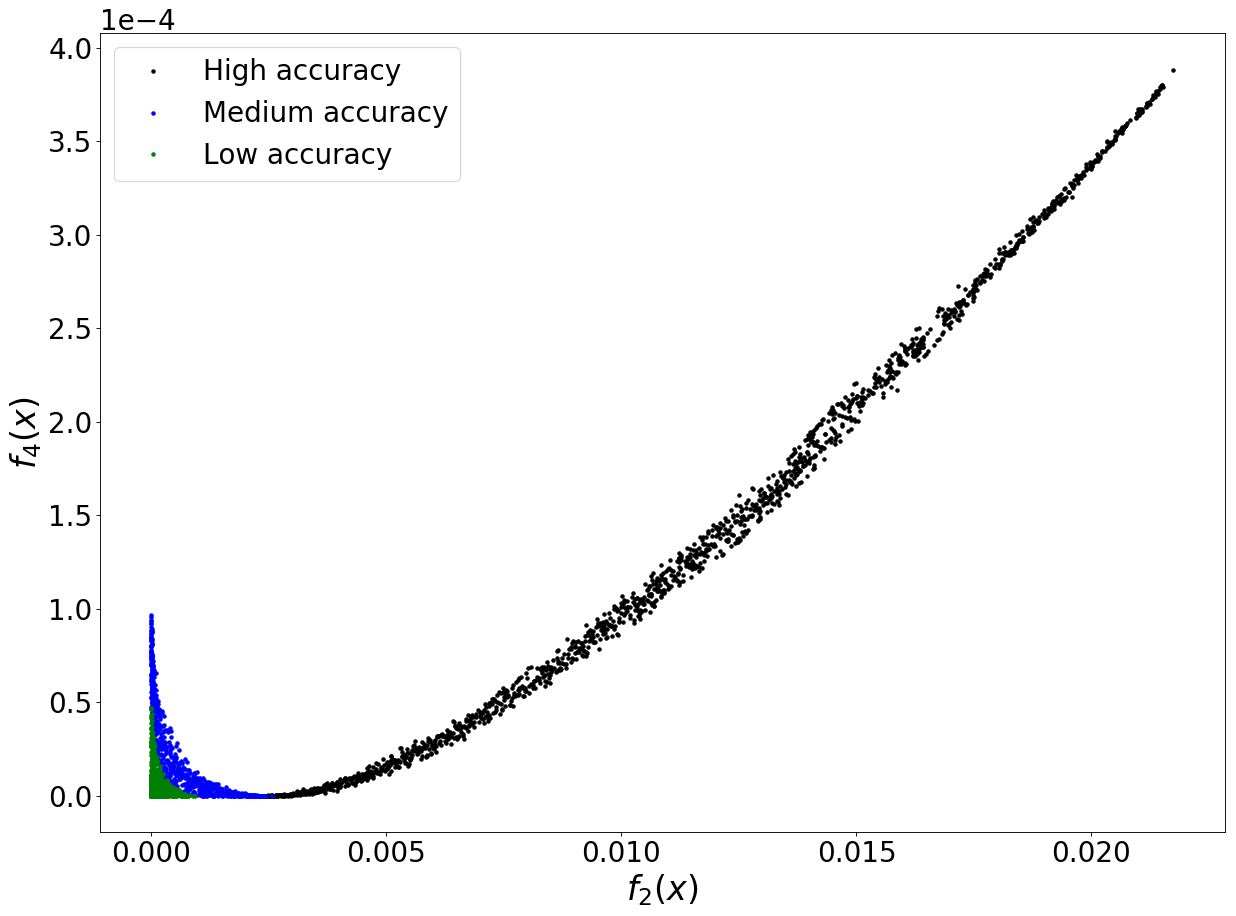

In [23]:
print len(f1_arrays7)
import matplotlib.cm as cm
colors = cm.rainbow(f1_arrays7/np.max(f1_arrays7))
idx_red = np.where(f1_arrays7 < (np.max(f1_arrays7) - np.min(f1_arrays7))*1.5/10 + np.min(f1_arrays7))
idx_blue = np.where((f1_arrays7 >= (np.max(f1_arrays7) - np.min(f1_arrays7))*1.5/10 + np.min(f1_arrays7)) \
                    & (f1_arrays7 < (np.max(f1_arrays7) - np.min(f1_arrays7))*4/10 + np.min(f1_arrays7)))
idx_green = np.where(f1_arrays7 >= (np.max(f1_arrays7) - np.min(f1_arrays7))*4/10 + np.min(f1_arrays7))


fig = plt.figure(figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
# ax.plot(training_loss, training_obj2, 'k.', lw=2)
ax.plot(f3_arrays7[idx_red], f2_arrays7[idx_red],  'k.', label = 'High accuracy') #color=colors   higher accuracy
ax.plot(f3_arrays7[idx_blue], f2_arrays7[idx_blue],  'b.', label = 'Medium accuracy') #color=colors  middle accuracy
ax.plot(f3_arrays7[idx_green], f2_arrays7[idx_green],  'g.', label = 'Low accuracy') #color=colors lowest accuracy

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xlabel('$f_2(x)$', fontsize=30)
ax.set_ylabel('$f_4(x)$', fontsize=30)
ax.legend(fontsize = 25)

plt.tight_layout()
plt.show()

figure_path = "figs/COMPAS_threeObj_EODI_2.pdf"
fig.savefig(figure_path, bbox_inches='tight')

In [44]:
print len(idx_red[0]), len(idx_blue[0]), len(idx_green[0])

1368 866 906


In [26]:
print colors

[[1.         0.13510525 0.067708   1.        ]
 [1.         0.13510525 0.067708   1.        ]
 [1.         0.13510525 0.067708   1.        ]
 ...
 [1.         0.11065268 0.05541147 1.        ]
 [1.         0.09840028 0.04925994 1.        ]
 [1.         0.09840028 0.04925994 1.        ]]


In [22]:
def remove_pts(list_f1, list_f2, list_f3, list_pts, num):
    list_f1_idx = np.argsort(list_f1)[:-num]
    return list_f1[list_f1_idx], list_f2[list_f1_idx], list_f3[list_f1_idx], list_pts[list_f1_idx]

In [25]:
f1_arrays7, f2_arrays7, f3_arrays7, point_arrays7 = remove_pts(f1_arrays7, f2_arrays7, f3_arrays7, point_arrays7, 2)

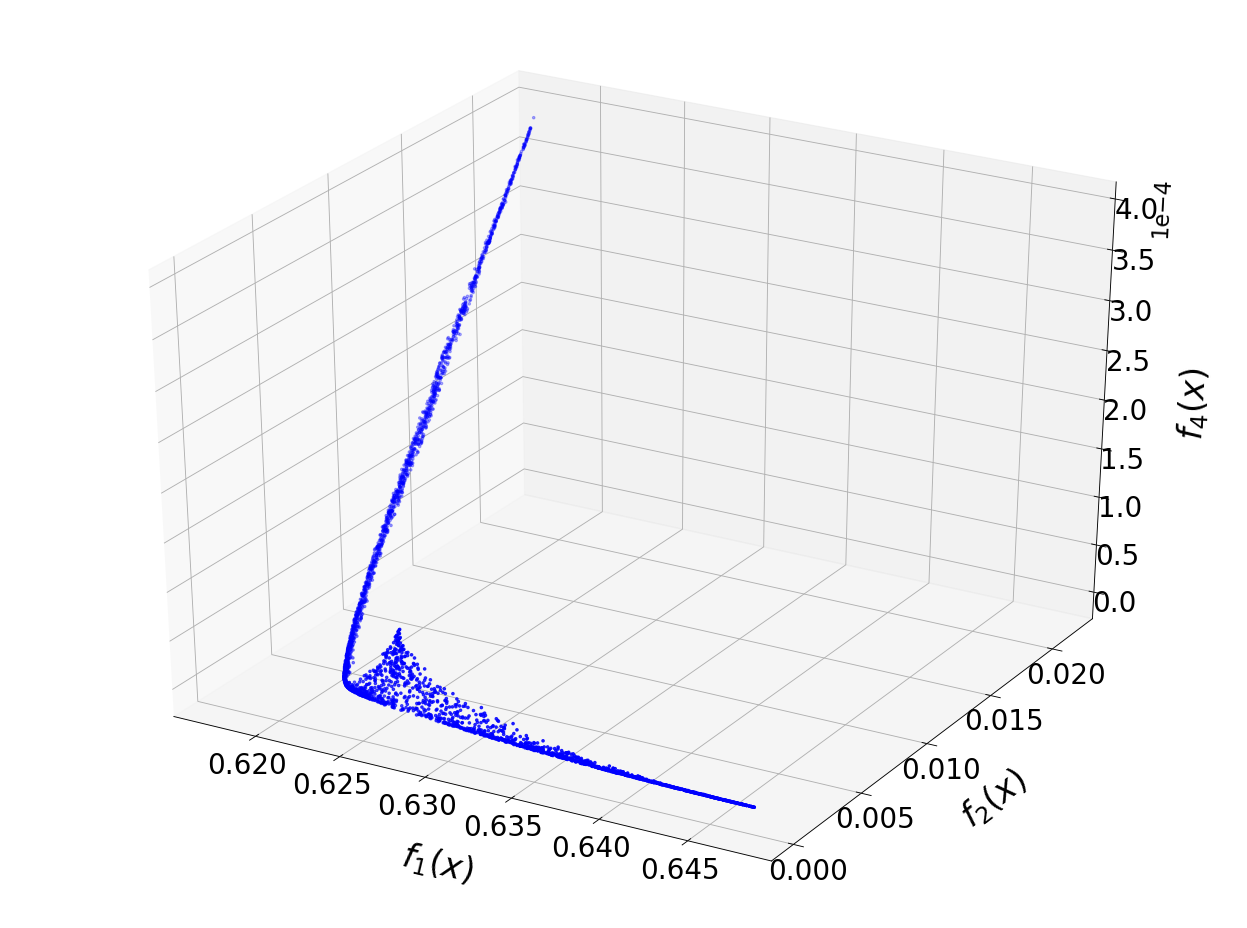

In [31]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
# ax = fig.add_subplot(111, projection='3d')
ax = fig.gca(projection='3d')
# ax.scatter(f1_arrays7[idx_red], f2_arrays7[idx_red], f3_arrays7[idx_red], c='r', marker='.')
# ax.scatter(f1_arrays7[idx_blue], f2_arrays7[idx_blue], f3_arrays7[idx_blue], c='b', marker='.')
# ax.scatter(f1_arrays7[idx_green], f2_arrays7[idx_green], f3_arrays7[idx_green], c='g', marker='.')

# ax.xaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.zaxis.set_tick_params(labelsize=25)
plt.ticklabel_format(style='sci', axis='z', scilimits=(0,0), useMathText=True)

ax.set_xlabel('\n$f_1(x)$', fontsize = 30, linespacing=3)
ax.set_ylabel('\n$f_2(x)$', fontsize = 30, linespacing=3)
ax.set_zlabel('\n$f_4(x)$', fontsize = 30, linespacing=3)
# ax.zaxis.set_major_locator(LinearLocator(10))

ax.scatter(f1_arrays7, f3_arrays7, f2_arrays7, c='b', marker='.')
plt.tight_layout()
plt.show()

figure_path = "figs/COMPAS_threeObj_EODI.pdf"
fig.savefig(figure_path, bbox_inches='tight')

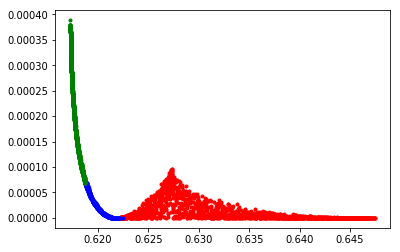

In [51]:

idx_red = np.where(f3_arrays7 < (np.max(f3_arrays7) - np.min(f3_arrays7))*1.0/10 + np.min(f3_arrays7))
idx_blue = np.where((f3_arrays7 >= (np.max(f3_arrays7) - np.min(f3_arrays7))*1.0/10 + np.min(f3_arrays7)) \
                    & (f3_arrays7 < (np.max(f3_arrays7) - np.min(f3_arrays7))*4.0/10 + np.min(f3_arrays7)))
idx_green = np.where(f3_arrays7 >= (np.max(f3_arrays7) - np.min(f3_arrays7))*4.0/10 + np.min(f3_arrays7))

plt.plot(f1_arrays7[idx_red], f2_arrays7[idx_red],  'r.') #color=colors   low DI
plt.plot(f1_arrays7[idx_blue], f2_arrays7[idx_blue],  'b.') #color=colors  middle DI
plt.plot(f1_arrays7[idx_green], f2_arrays7[idx_green],  'g.') #color=colors high DI

# plt.xlim(min(f2_arrays7), max(f2_arrays7))
# plt.ylim(min(f3_arrays7), max(f3_arrays7))
plt.show()

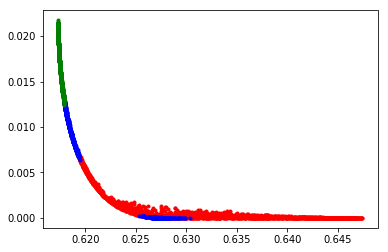

In [53]:

idx_red = np.where(f2_arrays7 < (np.max(f2_arrays7) - np.min(f2_arrays7))*1.0/10 + np.min(f2_arrays7))
idx_blue = np.where((f2_arrays7 >= (np.max(f2_arrays7) - np.min(f2_arrays7))*1.0/10 + np.min(f2_arrays7)) \
                    & (f2_arrays7 < (np.max(f2_arrays7) - np.min(f2_arrays7))*4.0/10 + np.min(f2_arrays7)))
idx_green = np.where(f2_arrays7 >= (np.max(f2_arrays7) - np.min(f2_arrays7))*4.0/10 + np.min(f2_arrays7))

plt.plot(f1_arrays7[idx_red], f3_arrays7[idx_red],  'r.') #color=colors   low FNR
plt.plot(f1_arrays7[idx_blue], f3_arrays7[idx_blue],  'b.') #color=colors  middle FNR
plt.plot(f1_arrays7[idx_green], f3_arrays7[idx_green],  'g.') #color=colors high FNR

# plt.xlim(min(f2_arrays7), max(f2_arrays7))
# plt.ylim(min(f3_arrays7), max(f3_arrays7))
plt.show()

In [ ]:
# f1:loss, f2: Equal FNR, f3: disparate impact

In [5]:
SEED_arr = [112233455, 666, 889099, 558866, 559966, 99998866, 99888866, 9966668, 99677808, 7542229,  \
            11234455, 6600451, 8852099, 110036, 277066, 277066, 900186, 9820816, 908253, 1089532]
num_data = range(1000, 6001, 500)
data_idx = 6

In [6]:
prob = func.Fairness_LogRe_DIEO_m3('data/Adult_income_gender_reduced.txt', 'Adult_income_gender', 1, SEED_arr[data_idx], num_data[data_idx], 'train')
run = pfsmg.Main_SMG_m3(prob)

run.max_len_pareto_front = 3000

## key parameters
run.point_per_iteration = 2 
run.num_steps_per_point = 3 
run.stepsize = 2.1 
run.step_scheme = 3
run.alpha = 1.0/3 
run.discount_iter_interval = 80 
run.batch1_init = 80 
run.batch1_factor = 1.005 
run.batch1_max = 1 
run.batch2_init = 80  
run.batch2_factor = 1.005 
run.batch2_max = 1.0/2  

## other parameters
run.num_starting_pts = 5
run.percent_explore = 0.4 
run.f1_explore_interval = 15 
run.f2_explore_interval = 1000 

run.f1_explore_pt_per_iter = 2 
run.f2_explore_pt_per_iter = 1 
run.f1_num_steps_per_point = 3*run.num_steps_per_point 
run.f2_num_steps_per_point = 2*run.num_steps_per_point 

run.num_max_hole_points = 5 
run.max_hole_explore_pt_per_iter = 2*run.point_per_iteration 
run.max_hole_num_steps_per_point = run.num_steps_per_point 
run.max_hole_only = False 
run.dense_threshold = 1.0/1400

#Training data size:  4000
Sensitive feature index:  1
Sum of positive ones:  2719.0


In [62]:
x = np.random.uniform(prob.lb, prob.ub, [1, prob.n])
print prob.g2(x).shape

(52,)


In [12]:
f1_arrays7, f2_arrays7, f3_arrays7, point_arrays7, total_time_smg = run.main_SMG()

[0.21274024 0.00962477 0.25905405]
[0.34110333 0.16284122 0.00062935]
[0.22940169 0.0264668  0.06919706]
[0.36268942 0.00662687 0.36516974]
[0.09417593 0.005514   0.09609666]
[0.27891016 0.07951322 0.0322139 ]
[0.32644269 0.06232899 0.06236754]
[0.35935306 0.06876851 0.09200659]
[1.66107520e-01 3.07466643e-02 9.14865883e-05]
[0.26237699 0.23722696 0.26891406]
[0.36634416 0.14248623 0.12016347]
[0.11292802 0.01783284 0.01718451]
[0.30096668 0.01457072 0.02991533]
[0.6316271  0.02245131 0.00644431]
[0.4298194  0.00046966 0.07994233]
[0.72420703 0.00551861 0.01396265]
[0.35173692 0.00205362 0.01364211]
[0.27349731 0.00037977 0.01103064]
[0.24285978 0.00296107 0.02301442]
[0.17009921 0.00477859 0.04020489]
[0.29506052 0.00321311 0.00588668]
[0.25246003 0.00234331 0.07371483]
[0.45985176 0.00957671 0.01513393]
[0.49083216 0.00442114 0.05175555]
[1.16403046 0.0039946  0.01447055]
[1.09142349 0.00691148 0.16302595]
[1.08381839 0.0014726  0.09395586]
[0.72941598 0.         0.4138636 ]


ValueError: matrix G is not positive definite

In [48]:
## dump data into log file
logfile = "pickle/COMPAS/three_obj/Adult_EODI_m3_pf3000_gap1400.pickle"
pickle.dump([prob.data_name, total_time_smg, run.num_grad_eval_f1, \
             run.num_grad_eval_f2, run.num_grad_eval_f3, run.num_iter, f1_arrays7, \
             f2_arrays7, f3_arrays7, point_arrays7], open(logfile,"wb"))

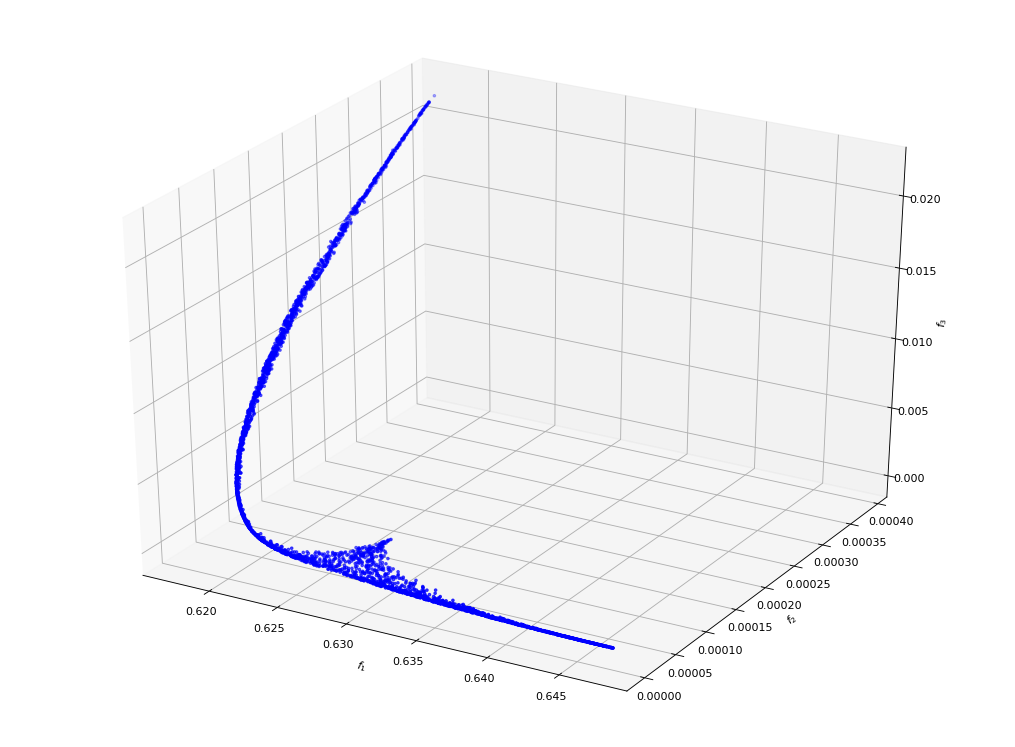

In [49]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(f1_arrays7, f2_arrays7, f3_arrays7, c='b', marker='.')

ax.set_xlabel('$f_1$')
ax.set_ylabel('$f_2$')
ax.set_zlabel('$f_3$')

plt.show()